# 'Seeing' digits: an interpretability dive into MLPs trained on MNIST data

## Part 01. Investigating the importance of normalization

## 0. The why?

My goal is to start digging into some tools used in interpretability. Looking at any paper on the subject we researchers probing the inner layers of models, asking questions like

> What 'features' does the model learn? Do neurons specialize?

Take the Anthropic paper *"Toy Models of Superposition"*, for example — it notes that some models, especially vision models, learn **interpretable features**: neurons that respond to horizontal lines, floppy ears, curves, and so on. These are patterns that we can understand, and when a neuron cleanly represents such a pattern, we call it interpretable. The goal-broadly-will be to interpret (understand) the black box of neural networks. But before that, the question that we hope to start working towards in this notebook is how do we begin to understand what neurons are specializing in? How do we ask what individual neurons look for in the data, and how do we study the specifics of the model as training evolves. We need to build an *interpretability toolbox* that will allow us to address these questions, and ultimately aid in our interpretation of other projects/repos that we have in the pipeline. 




---
**Interpretability tools** This notebook will just be scratching the surface but towards the goal of understanding neural networks we need to be able to 'probe' inner layers and neurons to 'see' how they respond during training and eventually to understand what they are looking for in the data. We begin by asking basic questions, like those raised in Karpathy’s Zero-to-Hero series:
- how does data normalization (or rather non-normalization) affect model behavior?
- What happens to hidden layer activations during training?
- Do neurons become inactive (“dead”) or oversaturated? (moving this to the next notebook)

From there, we'll get into tools like:
- Activation histograms and sparsity analysis
- Gradient tracking
- PCA or t-SNE on hidden representations
- Class-wise activation probing


---
**Notebook plan** (for now)
1) The first thing we do (in notebook 01) is attempt to understand the most naive (baseline) approach: take non-normalized MNIST data and run it through an MLP. What happens to the activations in the hidden layers? Specifically we study the statistics using histograms to aid in our understanding.
2) In notebook 02 we continue probing the model in both forward and backward passes (via hooks). Ask about possible neuron death due to raw data and drifting means/growing variance. 
3) In notebook 03 we will normalize the data and see how the model improves (if it does). Once we have a solid MLP where the activation statistics do not fluctuate too much through the training evolution we set our sights on more specific interpretability tools: gradient tracking, activation heatmaps/trajectories, PCA/t-SNE, etc.
4) We may then compare both normalized, and un-normalized setups to see/understand how tweaking the data (and the model) helps the model specialize.
5) In notebook 04 we will try the same with a CNN where we expect the spacial model to do much better but also (hopefully) be much more interpretable.


---
**Why MNIST**? There are many reasons to start here and they might not seem overly 'sexy' given the state of the art but I think it is a useful dataset to work on and is very natural starting place once we understand MLPs: 
1) MNIST is arguably one of the most basic training examples and one that we understand fairly well
2) MLPs perform fairly well on this dataset but with vectorized data there might be more space for vague interpretability
3) CNNs are the spacial models that seem to specialize a bit more and hence should be more clearly interpretable
4) We ended our [Micrograd experimentation](https://github.com/eriktholmes/Zero-to-hero-course/tree/main/episode-1/experiments/MNIST) with the MNIST data so why not pick up there!?

## 1. Overview/goals

This notebook is the first in a multi-part interpretability exploration. Here, we focus solely on a baseline MLP trained on non-normalized MNIST data, and we ask:

> - What happens to internal activations during training?
> - How do statistics like mean and standard deviation evolve layer-by-layer?
> - Do we observe signs of saturation, instability, or neuron death?
> - Are these effects uniform across digits, or are some classes more chaotic than others?

To answer these questions, we log and visualize:

> - Layerwise activations (histograms across training epochs)
> - Mean/std drift for all data as well as specific class (digit) data
> - Early signs of saturation or instability before normalization is introduced\
> ...No PCA, CNNs, or advanced probing tools are introduced yet — the goal is to establish an empirical baseline that later tools will be compared against.

***Disclaimer** I don’t claim to be an expert on these tools yet, but part of the point is to learn by doing, document that process, and build a foundation I can use in future projects. Once the MLP is running I’ll upgrade to a CNN (likely in a different notebook) to see what kinds of differences emerge, both in performance and (hopefully) in how the network learns to represent digits.*

## 2. MNIST data

### Section 2: Overview
We will proceed as follows:

**2.1.** Download and batch data (without normalization): the goal of this step is to have a baseline to compare future experiments\
**2.2.** Investigate statistics before training: **Raw input mean**: 0.1307, **Raw input std**: 0.3015. \
We also include some histograms of the raw data to accompany these statistics: there is a lot of white space in these images so we expect big peaks in the hisstograms near 0, and again near 1. We also expect different distributions based on digits (there is less marking for a '1' than for a '0' or '8') so we specialize this approach to individual digits as well. We will use this in the following sections to see if our model does better with certain digits than others. 
> **Visualizations**
>  1) histogram of pixel data for first 1000 training examples
>  2) histogram of pixel data based on digit
>  3) bar chart of mean pixel data per digit
>  4) mean $\pm$ std per digit


### 2.1. MNIST data download/batching

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 2.2. Some statistics/visualizations

In [16]:
means = []
stds = []

for xs, _ in train_loader:
    xs = xs.view(xs.size(0), -1)
    means.append(xs.mean(dim=1))
    stds.append(xs.std(dim=1))

all_means = torch.cat(means)
all_stds = torch.cat(stds)

print(f'Raw input mean: {all_means.mean():.4f}')
print(f'Raw input std: {all_stds.mean():.4f}')

Raw input mean: 0.1307
Raw input std: 0.3015


#### 2.3. Visualizations

#### First, we visualize the actual pixel data distributions for the first 1000 examples
1) We create a list of all pixel data for the first 1000 images
2) We create a dictionary of lists based on label to see if there is a difference in pixel distributions
3) We plot each of the above to visualize the distributions

In [201]:
# Want to gather some actual data for plotting purposes. 
# 1. We will collect all the pixel data
# 2. We collect pixels data based on digits

all_pixels = []
digit_pixels = {i: [] for i in range(10)}
count = 0

for x, y in train_dataset:
    count += 1
    x = x.view(-1)
    all_pixels.append(x)

    digit_pixels[y].append(x.view(-1))

    if count >= 1000:
        break

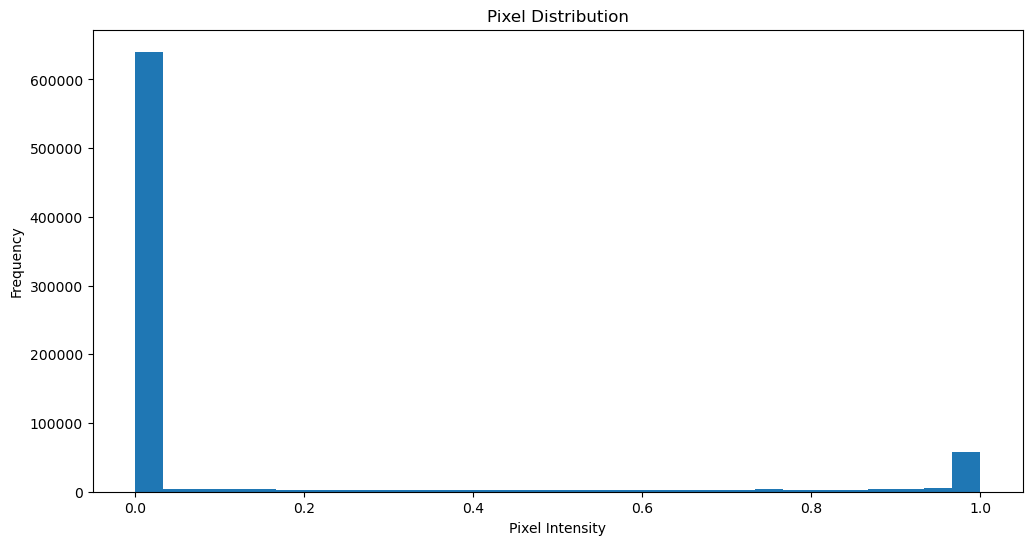

In [203]:
# Take the pixels list and concatenate to create a single 1D tensor
all_pixel_data = torch.cat(all_pixels, dim=0).view(-1)

plt.figure(figsize=(12, 6))
# Plot the data using a histogram with 30 bins
plt.hist(all_pixel_data.numpy(), bins=30)
plt.title("Pixel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

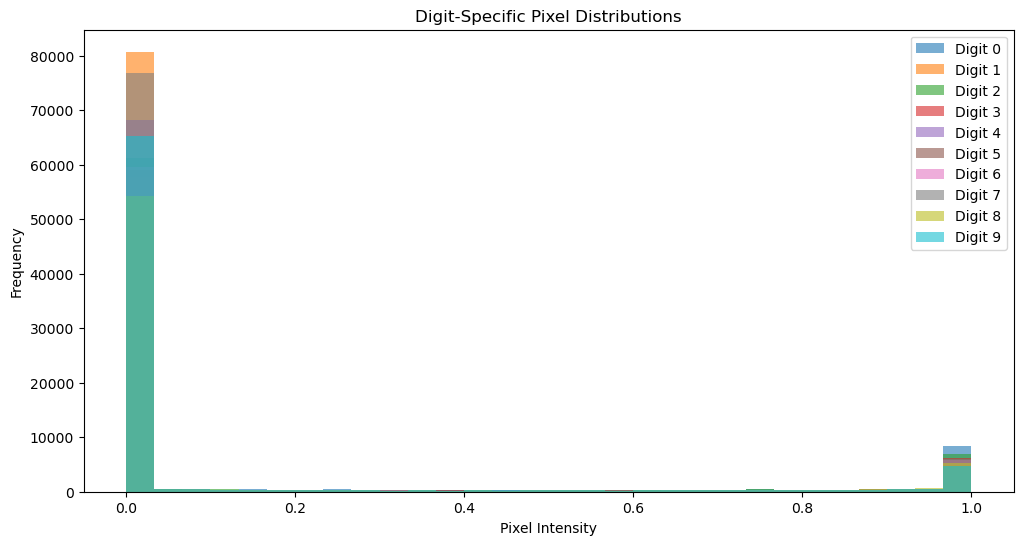

In [205]:
# Now, we do the same but with our digit specific data (we just want to see the differences in pixel distributions... there should be some!)
plt.figure(figsize=(12, 6))
means = []
stds = []
for i in range(10):
    digit_pixel_data = torch.cat(digit_pixels[i], dim=0).view(-1)
    plt.hist(digit_pixel_data.numpy(), bins=30, alpha=0.6, label=f'Digit {i}')
    means.append(digit_pixel_data.mean().item())
    stds.append(digit_pixel_data.std().item())
    
plt.title("Digit-Specific Pixel Distributions")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

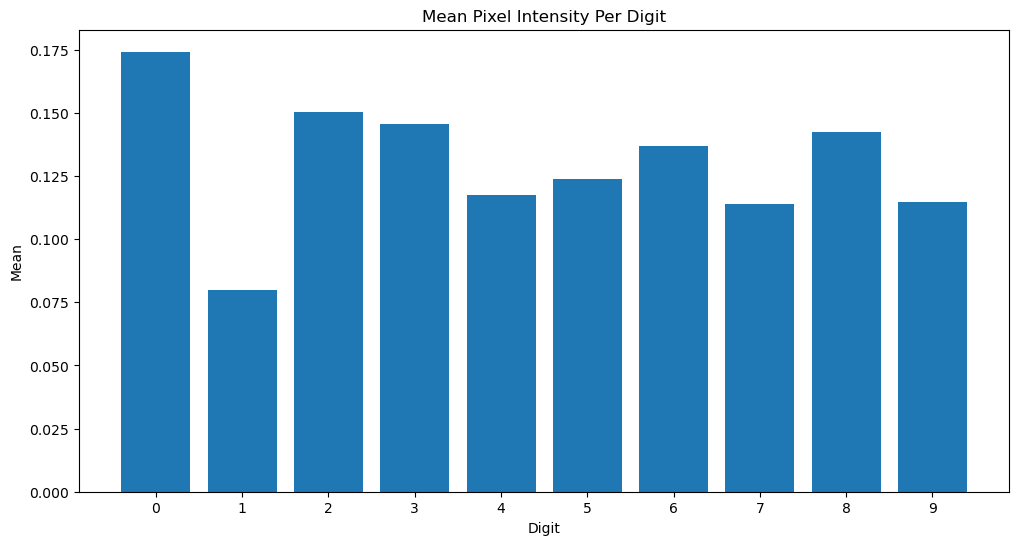

In [855]:
plt.figure(figsize=(12,6))
plt.bar(range(10), means)
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Mean Pixel Intensity Per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean")
plt.show()

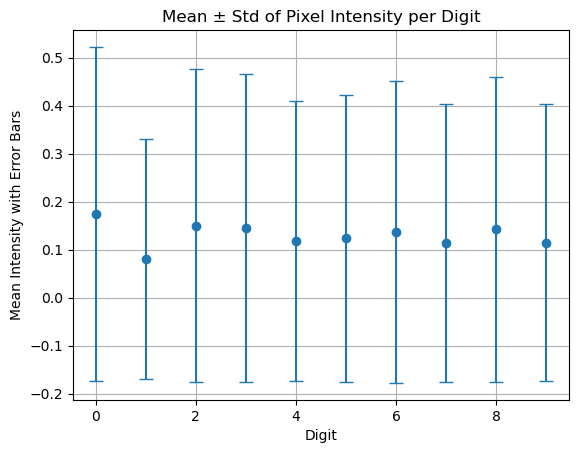

In [209]:
plt.errorbar(range(10), means, yerr=stds, fmt='o', capsize=5)
plt.title("Mean ± Std of Pixel Intensity per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean Intensity with Error Bars")
plt.grid(True)
plt.show()

## 3. Building an interpretable MLP and training our digit classifier (w/o normalization)

### Section 3: Overview
<!--*This sections works on the model without normalizing the data for comparison purposes*\-->
**3.1.** Build model\
**3.2.** Train model and track activations in layer 1 through training (after 20 epochs)\
    - **Loss**: 0.1437, **Accuracy**: 94.94%\
**3.3.** Test model\
    - **Accuracy**: 95.07%\
**3.4.** Train model again with activation tracking throughout the model (layer1, relu1, layer2, relu2, final logits)

### 3.1. Basic (2 hidden layer) MLP with ReLU activation
We attempt to make this as 'interpretable' as possible so we are doing things very simply and making sure we can grab data as we go: i.e. by adding ```self.___#``` in the forward pass we are able to pluck out activations for analysis during training. In the future (below) sections we will do this in a more streamlined way using hooks so we can also track gradients.\
*Note to self: the paper ***Extracting and visualizing hidden activations and computational graphs of PyTorch models with TorchLens*** provides some motivation.*

In [885]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16,10)

    def forward(self, x):
        self.linear1_out = self.linear1(x)
        self.act1 = self.relu1(self.linear1_out)
        self.linear2_out = self.linear2(self.act1)
        self.act2 = self.relu2(self.linear2_out)
        self.logits = self.output(self.act2)
        return self.logits

### 3.2. Training (visualizing layer 1 activations)

In [891]:
model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activation_log = {'layer1': []}

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activation_log['layer1'].append(model.linear1_out.detach())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 2.0004, Accuracy: 30.0300%
Epoch 5 — Loss: 0.3171, Accuracy: 90.8967%
Epoch 10 — Loss: 0.2452, Accuracy: 93.0983%
Epoch 15 — Loss: 0.1988, Accuracy: 94.3133%


#### A helpful function for the next few sections/examples

In [895]:
def activation_viz(layer, list, title):
    plt.figure(figsize=(12, 6))
    for i in list:
        data = layer[i].flatten().numpy()
        plt.hist(data, bins=30, alpha=0.6, label=f'Epoch {i}')
    plt.title(f"{title} Activation Distributions")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

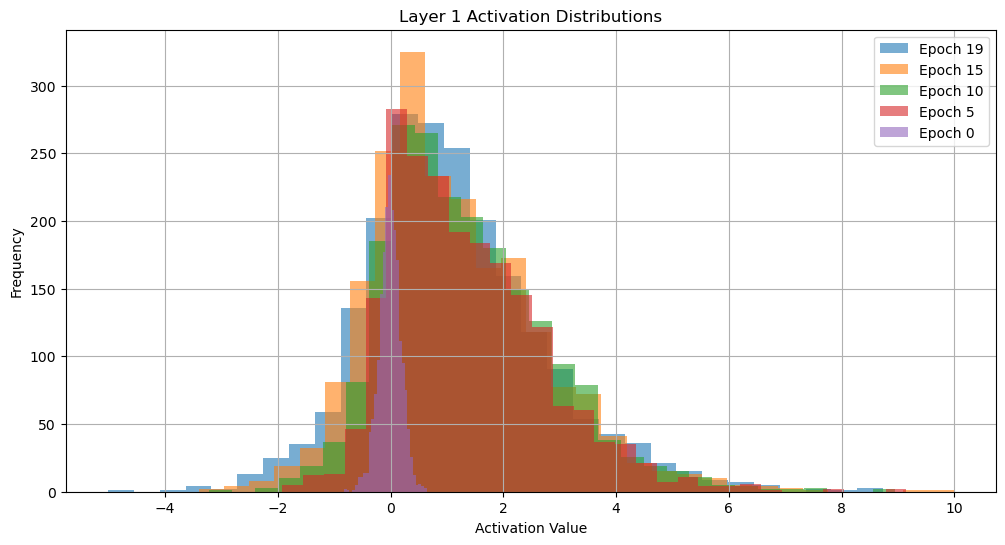

In [897]:
epochs_to_plot = [0 , 5, 10, 15, 19]

activation_viz(activation_log['layer1'], reversed(epochs_to_plot), 'Layer 1')

#### Quick thoughts
Even in the first layer, we see activations quickly spreading out — the histogram fanning out after just a few training steps - I reversed the epoch order here to make this more apparent. While the model still reaches decent accuracy on raw data (and test data), these unnormalized activations suggest poor calibration which would likely cause much more dramatic failure in deeper models. 

In short: non-normalized inputs lead to increasingly extreme activations, layer after layer. This fanning out is a recipe for vanishing or exploding gradients in deeper nets — and often means less stable learning overall.

Below, we’ll compare this to the normalized version, where activations are (hopefully :fingerscrossed) more compact.

### 3.3. Testing the model

In [899]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for xs, ys in test_loader:
        xs = xs.view(xs.size(0), -1)
        yout = model(xs)
        preds = torch.argmax(yout, dim=1)
        correct += (preds == ys).sum().item()
        total += ys.size(0)

print(f"Test Accuracy: {(correct / total)*100:.4f}%")

Test Accuracy: 94.8700%


### 3.4. Tracking all activations

In [1305]:
from collections import defaultdict

model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activations_log = defaultdict(list)

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activations_log['linear1'].append(model.linear1_out.detach().flatten())
            activations_log['act1'].append(model.act1.detach().flatten())
            activations_log['linear2'].append(model.linear2_out.detach().flatten())
            activations_log['act2'].append(model.act2.detach().flatten())
            activations_log['logits'].append(model.logits.detach().flatten())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.7801, Accuracy: 43.9533%
Epoch 5 — Loss: 0.3213, Accuracy: 90.9000%
Epoch 10 — Loss: 0.2480, Accuracy: 92.9633%
Epoch 15 — Loss: 0.1964, Accuracy: 94.3167%


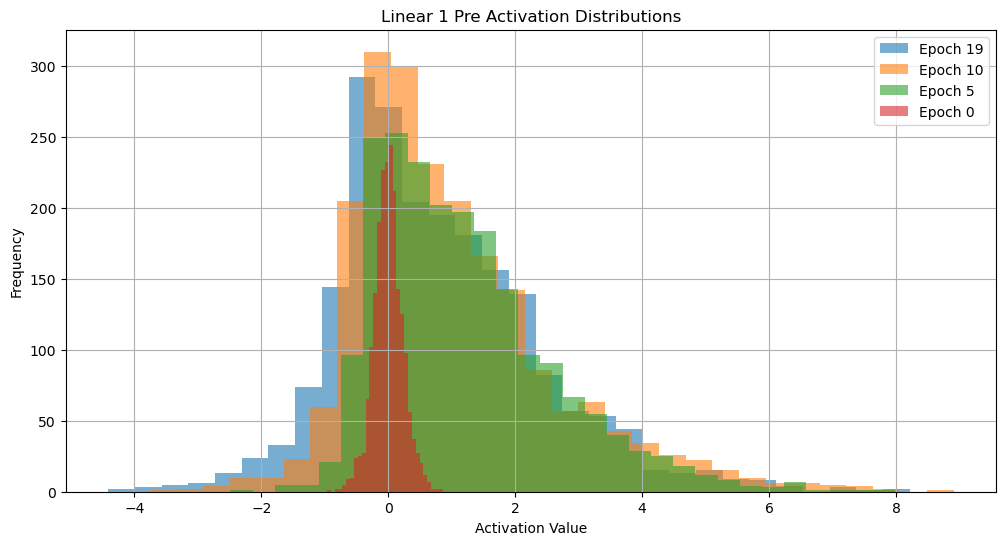

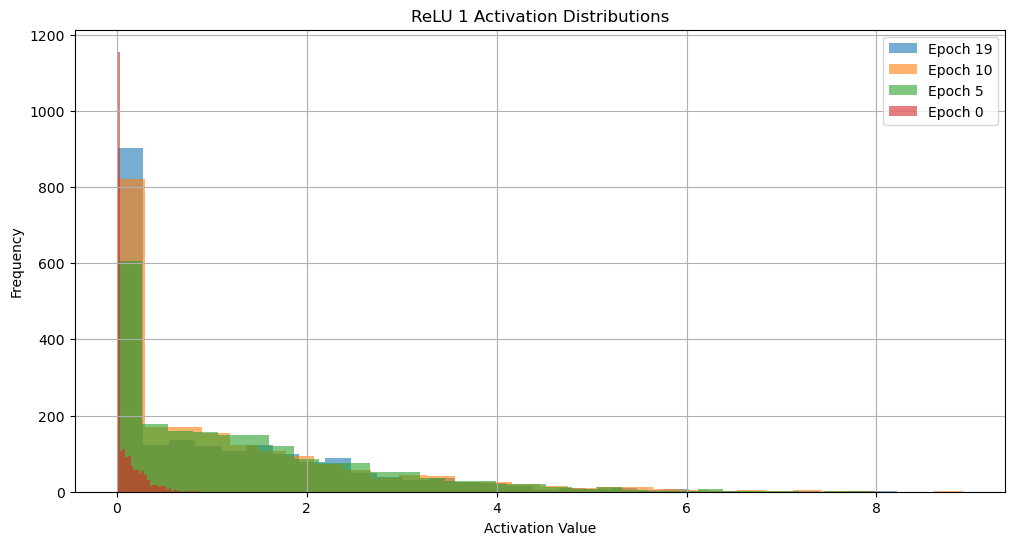

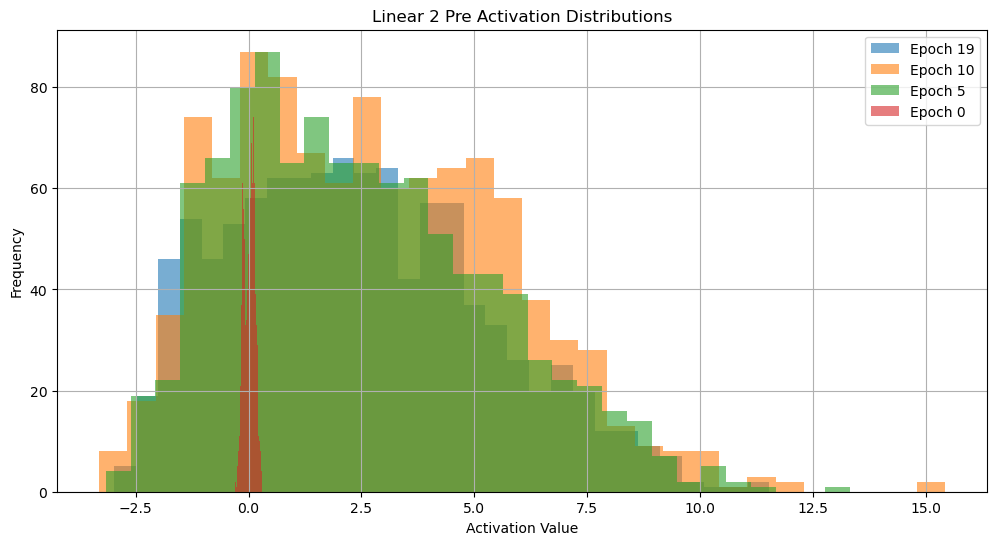

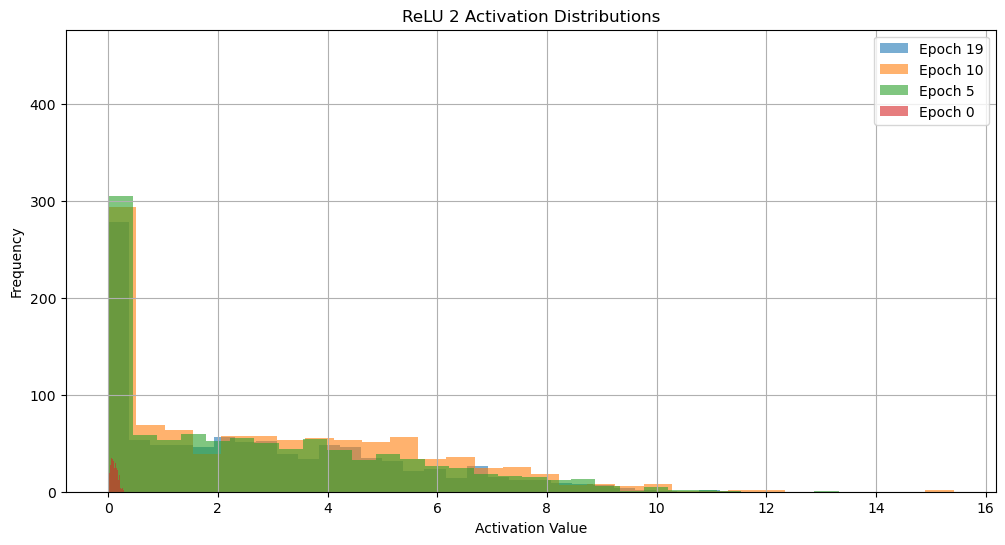

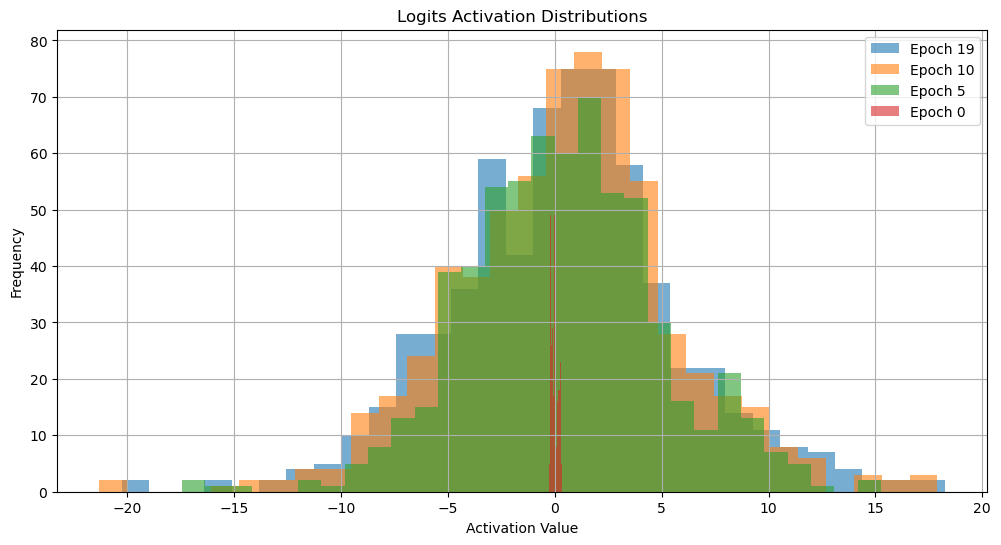

In [1324]:
epochs_to_plot = [19, 10, 5, 0]
activation_viz(activations_log['linear1'], epochs_to_plot, "Linear 1 Pre")
activation_viz(activations_log['act1'], epochs_to_plot, "ReLU 1")
activation_viz(activations_log['linear2'], epochs_to_plot, "Linear 2 Pre")
activation_viz(activations_log['act2'], epochs_to_plot, "ReLU 2")
activation_viz(activations_log['logits'], epochs_to_plot, "Logits")

In [1309]:


len(activations_log['linear1'])

20

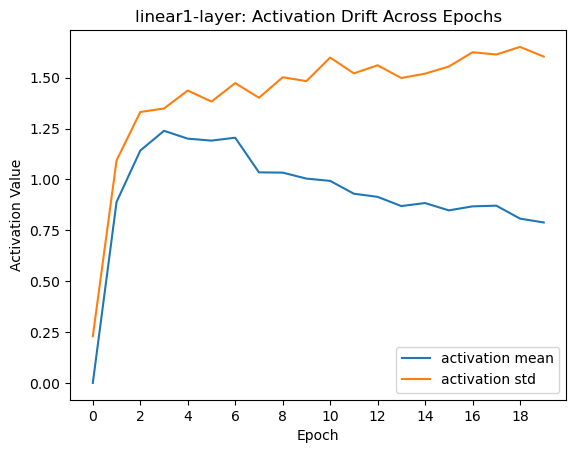

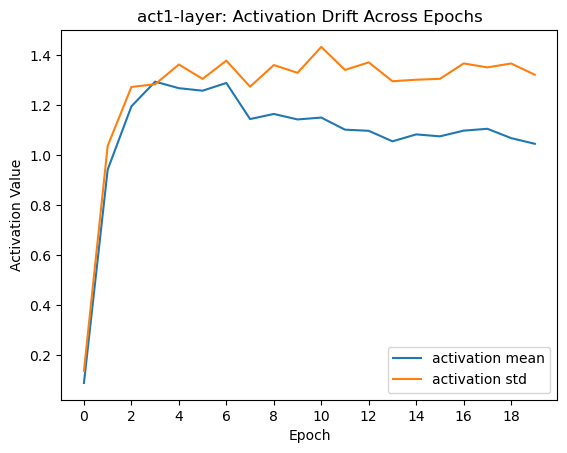

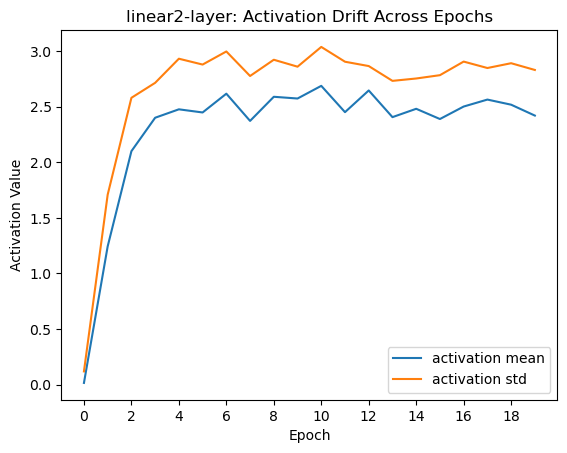

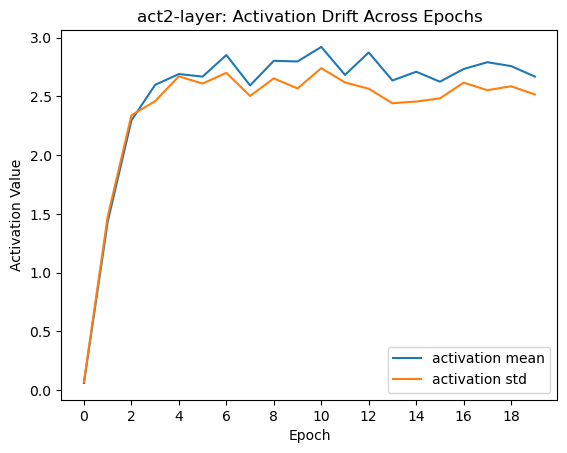

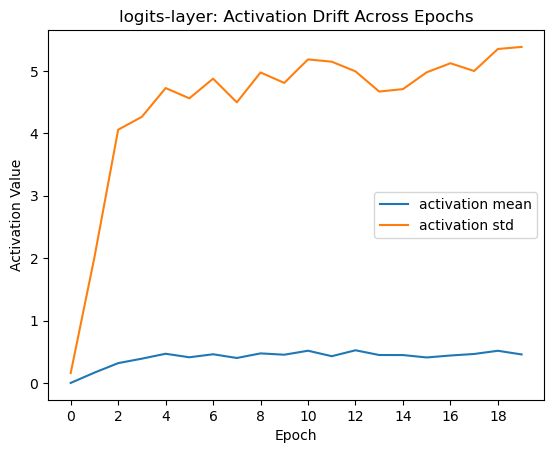

In [1315]:
for layer in ['linear1', 'act1', 'linear2', 'act2', 'logits']:
    act = layer
    epoch_means = []
    epoch_stds = []
    
    for i in range(20):
        epoch_means.append(activations_log[act][i].mean().item())
        epoch_stds.append(activations_log[act][i].std().item())
        #print(f'Epoch {i}: mean-{layer1_class_act[5][i].mean().item():.2f}, std-{layer1_class_act[5][i].std().item():.2f}')
    
    
    plt.plot(epoch_means, label="activation mean")
    plt.plot(epoch_stds, label="activation std")
    plt.title(f"{act}-layer: Activation Drift Across Epochs")
    plt.xticks([2*i for i in range(10)])
    plt.xlabel("Epoch")
    plt.ylabel("Activation Value")
    plt.legend()
    plt.show()
    plt.close()

### 3.5. Further reflections

Above we analyzed the distribution of activations across the entire forward pass, from the first hidden layer to the final logits. To highlight how the model’s internal representations evolve, we compare only the first, fifth, and final training epochs, which makes the change in distribution especially clear.

So again, even though we achieve reasonable performance on the test set the internal activations show how unstable the training process is.

Before moving on to normalization, let’s ask a couple more questions:

> 1) What about neuron death?  
> 2) What happens when we focus on specific classes (digits)?

The latter question should help us determine if this is a global issue (affecting all digits) or if it is really a local issue (affecting some classes more than others). We are drawn to this question because we did see some differences in the distribution across classes from section 2. 

### 3.6. Where do we fail!? 
Before moving on, let's just quickly look at some of the examples where our model fails.

In [913]:
correct = 0
total = 0

failures = []

with torch.no_grad():
    for img, y in test_dataset:
        total += 1
        x = img.view(-1, 28*28)
        yout = model(x)
        pred = torch.argmax(yout, dim=1)
        if pred == y:
            correct += 1
        else:
            failures.append((img, y, pred))

print(f'The model acheives {correct/total * 100: .2f}% accuracy on the test set... below we see some failures in the predictions')

The model acheives  94.97% accuracy on the test set... below we see some failures in the predictions


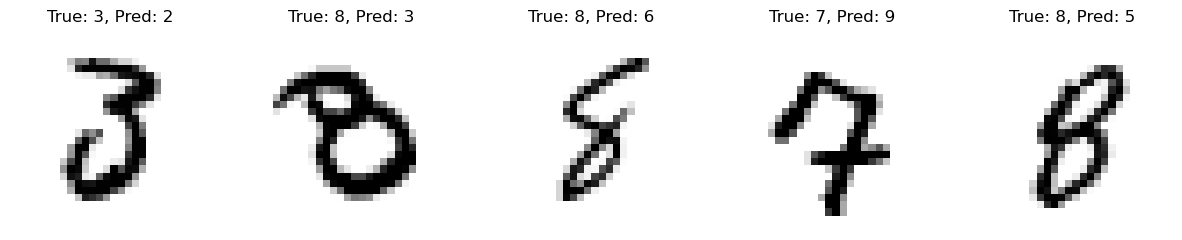

In [917]:
import matplotlib.pyplot as plt

ind = torch.randint(0, len(failures), (5,))

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for ax, i in zip(axes, ind):
    img, label, pred = failures[i.item()]
    ax.imshow(img.squeeze(), cmap='gray_r')
    ax.set_title(f'True: {label}, Pred: {pred.item()}')
    ax.axis('off')
plt.show()

#### Thoughts:
We can see that this is not great! In previous MNIST experiments (before the creation of this notebook) the failures we saw were a little more understandable. We hope the models predictions improve as we fine tune it a bit in future notebooks. 

## 4. Class based analysis

### Section 4 Overview:


### 4.1. The MLP

In [919]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16,10)

    def forward(self, x):
        self.linear1_out = self.linear1(x)
        self.act1 = self.relu1(self.linear1_out)
        self.linear2_out = self.linear2(self.act1)
        self.act2 = self.relu2(self.linear2_out)
        self.logits = self.output(self.act2)
        return self.logits

### 4.2. Class analysis

In [1191]:
from collections import defaultdict

class_act = defaultdict(list)
layer1_class_act = defaultdict(list)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0

    for count, (xs, ys) in enumerate(train_loader):
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        # Log activations from layer1 for one batch only
        #if count == 0:
        layer1_pre_activations = model.linear1_out.detach()  # shape: (batch_size, neurons)
        
        for act, label in zip(layer1_pre_activations, ys):
            class_act[label.item()].append(act)
    for k in class_act:
        layer1_class_act[k].append(torch.stack(class_act[k]).flatten())
        class_act[k] = []
            #for act, label in zip(layer2_post_activations, ys):
            #    class_act[label.item()].append(act)

    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.9506, Accuracy: 34.5033%
Epoch 5 — Loss: 0.3383, Accuracy: 90.2667%
Epoch 10 — Loss: 0.2614, Accuracy: 92.6100%
Epoch 15 — Loss: 0.2122, Accuracy: 93.9550%


tensor([6, 8])


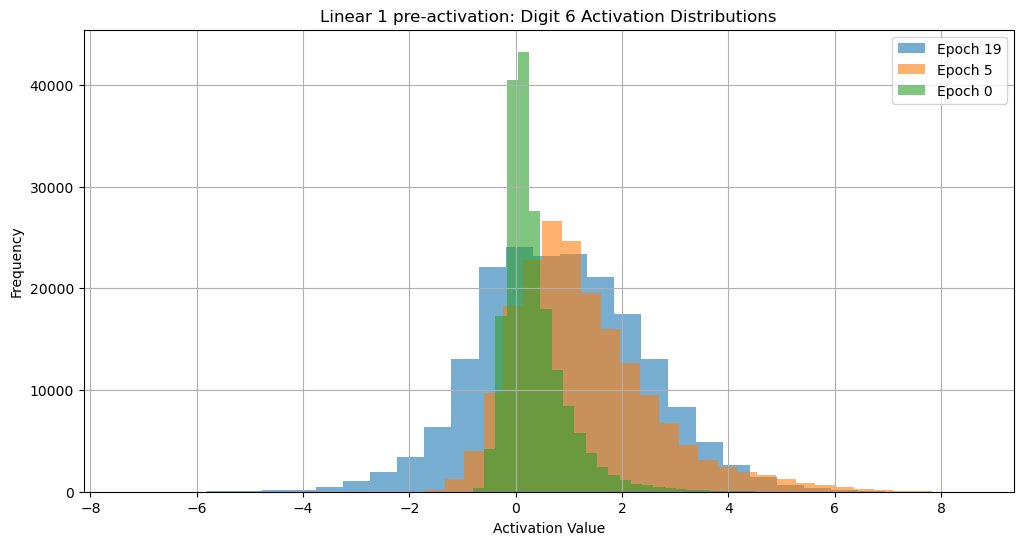

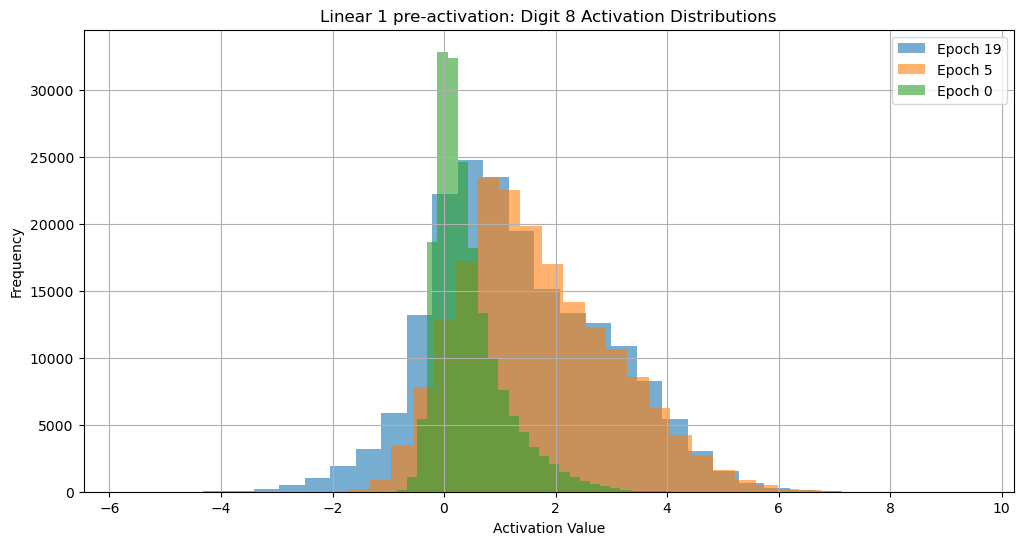

In [1276]:
ind = torch.randint(0, 10, (2,))
print(ind)
for i in ind:
    activation_viz(layer1_class_act[i.item()], [19, 5, 0], f"Linear 1 pre-activation: Digit {i.item()}")

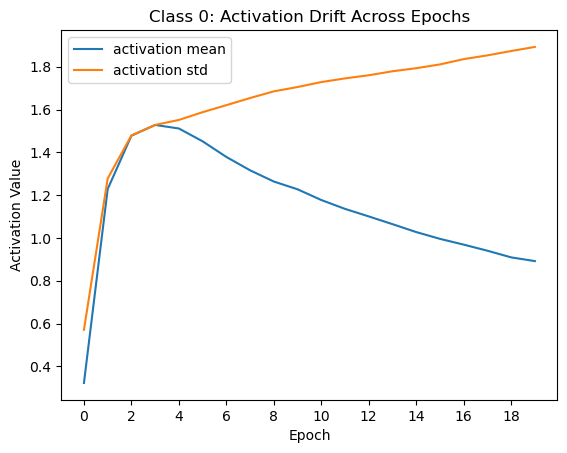

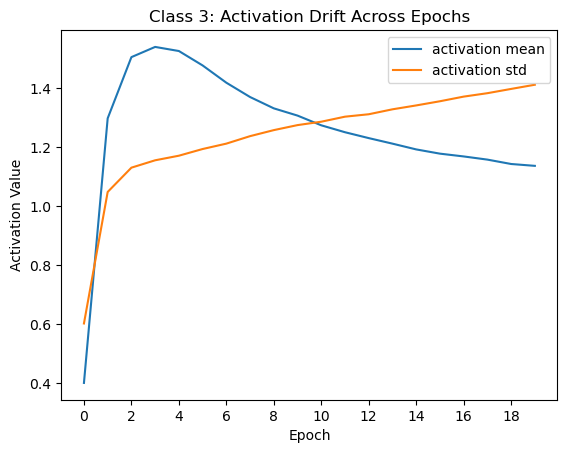

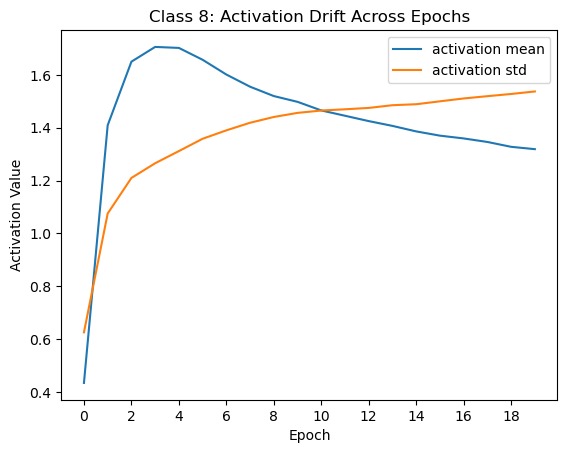

In [1296]:
for c in [0, 3, 8]:
    ex_class = c
    class_epoch_means = []
    class_epoch_stds = []
    
    for i in range(20):
        class_epoch_means.append(layer1_class_act[ex_class][i].mean().item())
        class_epoch_stds.append(layer1_class_act[ex_class][i].std().item())
        #print(f'Epoch {i}: mean-{layer1_class_act[5][i].mean().item():.2f}, std-{layer1_class_act[5][i].std().item():.2f}')
    
    
    plt.plot(class_epoch_means, label="activation mean")
    plt.plot(class_epoch_stds, label="activation std")
    plt.title(f"Class {ex_class}: Activation Drift Across Epochs")
    plt.xticks([2*i for i in range(10)])
    plt.xlabel("Epoch")
    plt.ylabel("Activation Value")
    plt.legend()
    plt.show()
    plt.close()

#### Quick recap
Okay, what we are doing above is capturing the activations of layer 1 based on a fixed class (e.g., digit "3") and plotted a histogram of these activations for various epochs. We again see the similar 'fanning out' issue for each digit, though we do see some seemingly different distributions/spreads.

To better understand how our non-normalized MLP evolves during training, we tracked the mean and standard deviation of activations in the first hidden layer across 20 epochs. Across classes we observe:
> - mean quickly increases (from ~.3 to ~1.5) before gradually declining. Note this this depends a bit on the class, though we do see a similar trend for each
> - the standard deviation, however, seems to increase throughout the epochs, even as the mean seems to stabilize

This tells us that even though the model was training “successfully” in terms of test accuracy (~94%), the internal representations were becoming increasingly unstable. The distribution of activations was not just drifting—it was spreading. This growing variance likely has cascading affects as the models get deeper and therefore we have excellent evidence for normalization (if we needed any extra motivation for this anyway!).




## 5. Reflections + future directions

The (restructured) goal of this notebook was to investigate why normalization matters and to explore how one might visualize and diagnose training behavior in a minimal MLP.

We built a simple, interpretable MLP trained on MNIST without input normalization, and tracked internal activations across layers and epochs. What we found:

  > - activations drift significantly with shifting means and growing variances.
  > - although the model achieved about 94% accuracy across training and testing data, there were some serious issues internally that likely hindered the trainnig and overall accuracy of the model.

This experiment gives us a concrete, interpretable reason to care about normalization: faster convergence, but also for controlling internal chaos.

In the next notebook, we’ll investigate:

- Neuron death and saturation
- Gradient tracking via hooks
- And how normalization methods like BatchNorm might change this activation landscape.
- More interpretability tools like PCA and class clustering

Again, the goal is to build an interpretability toolbox—starting small, but scaling toward models where these tools become essential.